# Transfer Learning: Cats vs Dogs using MobileNetV2

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

tfds.disable_progress_bar()


# 1. Load and preprocess data

In [ ]:
IMG_SIZE = 160
(raw_train, raw_val, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True, as_supervised=True
)

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example).shuffle(1000).batch(32)
val = raw_val.map(format_example).batch(32)
test = raw_test.map(format_example).batch(32)

# 2. Load base model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# 3. Add custom classifier

In [ ]:

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

# 4. Train

In [ ]:
history = model.fit(train, epochs=5, validation_data=val)

# 5. Evaluate

In [ ]:
loss, acc = model.evaluate(test)
print(f'Test accuracy: {acc:.4f}')

# 6. Fine-tune

In [ ]:
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = 5 + fine_tune_epochs
history_fine = model.fit(train, epochs=total_epochs,
                         initial_epoch=5, validation_data=val)


# 7. Plot training progress

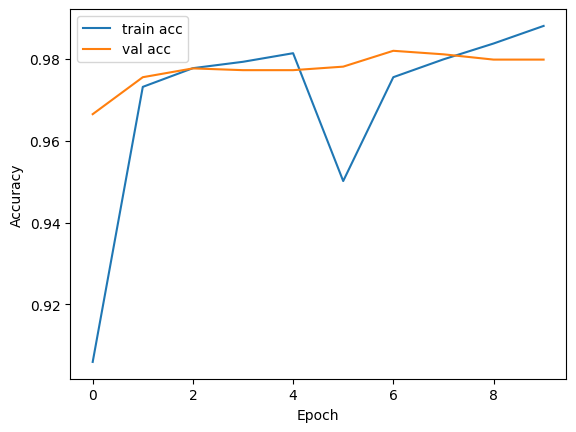

In [ ]:

plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='val acc')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.show()

# 8. Save model

In [ ]:
model.save('dogs_vs_cats.keras')